# Data Driven Forecasting of Hotel Booking Cancellations


**Team Members**: Pranav Dange and Vabhavi Tickoo

In [1]:
#uploading the csv file to google colab
from google.colab import files

uploaded = files.upload()

Saving Hotel Reservations.csv to Hotel Reservations.csv


In [2]:
#Importing the basic libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

#Importing the libraries for model building and tuning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import (f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, classification_report)
from sklearn.ensemble import RandomForestClassifier

#Library for to perform oversampling
from imblearn.over_sampling import SMOTE

#This library is used for feature selction process
from sklearn.feature_selection import chi2

In [3]:
#Importing the data
hotel_reservation_data =pd.read_csv("/content/Hotel Reservations.csv")

#Converting the column names to lower case
hotel_reservation_data.columns= hotel_reservation_data.columns.str.lower()

In [4]:
#printing the first 5 values from the imported data
hotel_reservation_data.head()

,booking_id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [5]:
#printing the last 5 values
hotel_reservation_data.tail()

,booking_id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled
36274,INN36275,2,0,1,2,Meal Plan 1,0,Room_Type 1,207,2018,12,30,Offline,0,0,0,161.67,0,Not_Canceled


In [6]:
#Getting the count of number of records and the columns present in the data
hotel_reservation_data.shape

(36275, 19)

In [7]:
#Validating the absence of null values in the data
hotel_reservation_data.isnull().sum()

booking_id                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [8]:
# Removing the unecessary columns from the data based on our EDA Analysis and the Confusion Matrix plotted in the EDA
cols_to_drop = ['booking_id', 'arrival_year', 'arrival_date']
hotel_reservation_data = hotel_reservation_data.drop(cols_to_drop, axis=1)

In [9]:
#Validating the dropping of columns
hotel_reservation_data.columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_month',
       'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
       'no_of_special_requests', 'booking_status'],
      dtype='object')

Now in the EDA Analysis we observed that there was a pattern in the tourist arrival and the hotel cancellation based on the Quaterly split hence we decided to add a new feature to improve our model performance and give the model more relevant feature to predict.

In [10]:
#Create conditions and corresponding values for each quarter
quarter_conditions = [
    (hotel_reservation_data['arrival_month'] <= 3),
    (hotel_reservation_data['arrival_month'] > 3) & (hotel_reservation_data['arrival_month'] <= 6),
    (hotel_reservation_data['arrival_month'] > 6) & (hotel_reservation_data['arrival_month'] <= 9),
    (hotel_reservation_data['arrival_month'] >= 10)]
quarters = ['Q2', 'Q3', 'Q4', 'Q1']

#Creating a new column based on the above conditions
hotel_reservation_data['quarter'] = np.select(quarter_conditions, quarters)

#Dropping the arrival month column after adding the new column
hotel_reservation_data = hotel_reservation_data.drop('arrival_month', axis=1)

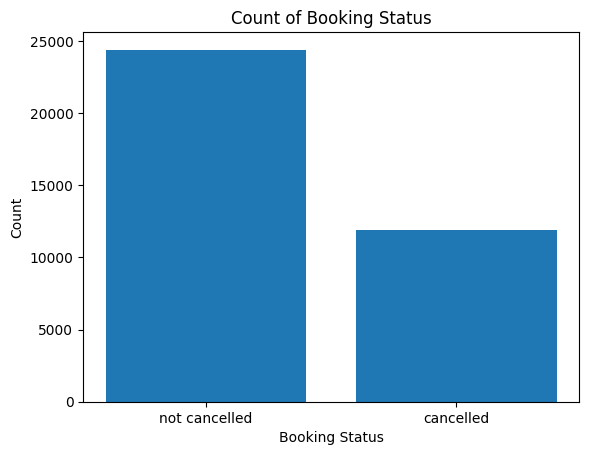

In [11]:
# create a bar plot
plt.bar(['not cancelled', 'cancelled'], hotel_reservation_data['booking_status'].value_counts())

# set the title and labels
plt.title('Count of Booking Status')
plt.xlabel('Booking Status')
plt.ylabel('Count')

# display the plot
plt.show()

As we see the imbalance in the predicted values we will be using SMOTE to handle this imbalance

As our data has categorical features apart from the numerical one's we would need to encode this in order to feed this data to the model so the next step performs this and we will transfer this data into a data frame

In [12]:
# One-hot encode the categorical variables and passing the data in a data frame
df = pd.get_dummies(hotel_reservation_data, drop_first=True)

In [13]:
#Validating the encoding was successful
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,...,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online,booking_status_Not_Canceled,quarter_Q2,quarter_Q3,quarter_Q4
0,2,0,1,2,0,224,0,0,0,65.00,...,0,0,0,0,1,0,1,0,0,0
1,2,0,2,3,0,5,0,0,0,106.68,...,0,0,0,0,0,1,1,0,0,0
2,1,0,2,1,0,1,0,0,0,60.00,...,0,0,0,0,0,1,0,1,0,0
3,2,0,0,2,0,211,0,0,0,100.00,...,0,0,0,0,0,1,0,0,1,0
4,2,0,1,1,0,48,0,0,0,94.50,...,0,0,0,0,0,1,0,0,1,0


In [14]:
#Performing the Train Test Split
X = df.drop('booking_status_Not_Canceled', axis=1)
Y = df['booking_status_Not_Canceled']

Now in order to select the best features and removing the reduntant features before feeding the model with the data we used the chi square test in order to arrange the features by their p values and dropping the features with high p values.

In [15]:
#Performing chi-square test on the features
chi_scores = chi2(X, Y)
p_values = pd.Series(chi_scores[1], index=X.columns)
p_values_sorted = p_values.sort_values(ascending=True)

<Figure size 1200x800 with 0 Axes>

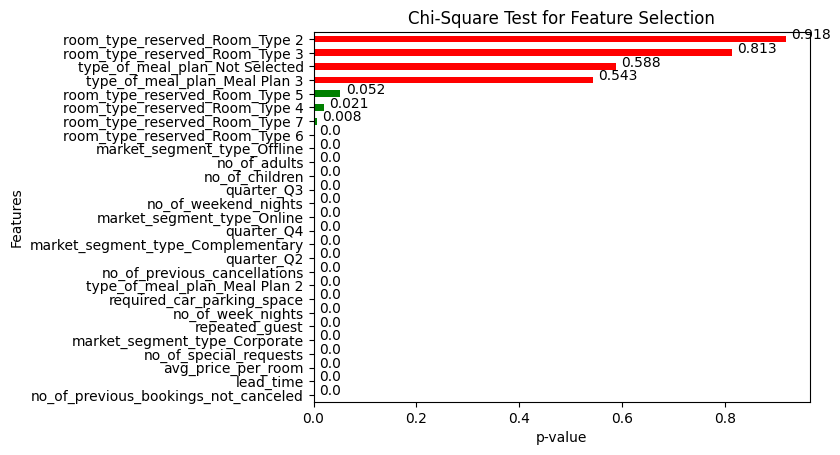

In [16]:
# Plot the p-values and we have color coded the graph based on the p values, we have given the the bar red color where the value is above 0.5 and the rest is colored as green
plt.figure(figsize=(12, 8))
fig, ax = plt.subplots()
colors = np.where(p_values_sorted < 0.5, 'green', 'red')# Adding color based on the p values
p_values_sorted.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('p-value')
ax.set_ylabel('Features')
ax.set_title('Chi-Square Test for Feature Selection')

# Add annotations for p-values to improve the readability
for i, v in enumerate(p_values_sorted):
    ax.text(v + 0.01, i, str(round(v, 3)), color='black', fontweight= 8)

plt.show()

In [17]:
#Dropping the features based on the above observations
X = X.drop(["room_type_reserved_Room_Type 2", 'room_type_reserved_Room_Type 3', 'type_of_meal_plan_Not Selected', 'type_of_meal_plan_Meal Plan 3'], axis=1)

In [18]:

#Function for confusion matrix
def print_confusion_matrix(model,Y_actual,labels=[1, 0]):
    Y_predict = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix( Y_actual, Y_predict, labels=[0, 1])
    df_confusion_matrix = pd.DataFrame(confusion_matrix, index = [i for i in ["Actual - No","Actual - Yes"]], columns = [i for i in ['Predicted - No','Predicted - Yes']])
    count = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    percentage = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(count,percentage)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_confusion_matrix, annot=labels,fmt='')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

#  Function to calculate model perforance scores
def print_metrics_score(model,flag=True):
    
    scores=[] 
    
    training_prediction = model.predict(X_train)
    testing_prediction = model.predict(X_test)
 
    
    training_accuracy = model.score(X_train,Y_train)
    testing_accuracy = model.score(X_test,Y_test)

    training_recall = metrics.recall_score(Y_train,training_prediction)
    testing_recall = metrics.recall_score(Y_test,testing_prediction)

    training_precision = metrics.precision_score(Y_train,training_prediction)
    testing_precision = metrics.precision_score(Y_test,testing_prediction)

    scores.extend((training_accuracy, testing_accuracy, training_recall, testing_recall, training_precision,testing_precision))
        
    if flag == True: 
        print("Model Accuracy on the Training Set Data : ", model.score(X_train,Y_train))
        print("Model Accuracy on the Testing Set Data : ", model.score(X_test,Y_test))
      
        print("Recall value on the Training Set Data : ", metrics.recall_score(Y_train,training_prediction))
        print("Recall value on the Testing Set Data : ", metrics.recall_score(Y_test,testing_prediction))
        
        print("Precision value on the Training Set Data : : ",metrics.precision_score(Y_train,training_prediction))
        print("Precision on on the Testing Set Data : ", metrics.precision_score(Y_test,testing_prediction))
    
    
    return scores

Model Accuracy on the Training Set Data :  0.9732598208132323
Model Accuracy on the Testing Set Data :  0.9710544452101999
Recall value on the Training Set Data :  0.9793830255282141
Recall value on the Testing Set Data :  0.977699772868057
Precision value on the Training Set Data : :  0.9808884562176564
Precision on on the Testing Set Data :  0.9789125491006823


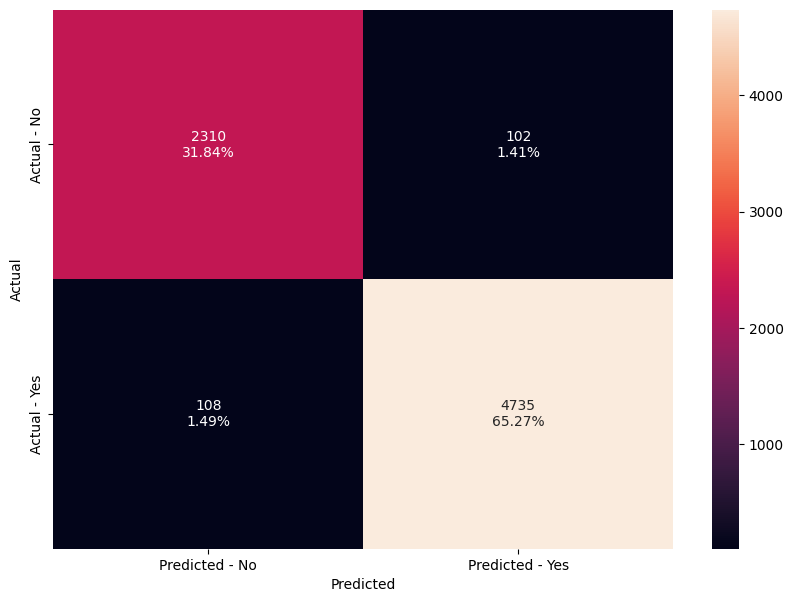

In [19]:
#Model training with 80:20 train test split and the random state is used to replicate the results
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 77)

#Performing oversampling to handle the imbalance in the prediction values
oversampling = SMOTE()
oversampling_X, oversampling_Y = oversampling.fit_resample(X, Y)
oversampling_X_train, oversampling_X_test, oversampling_Y_train, over_Y_test = train_test_split(oversampling_X, oversampling_Y, test_size=0.2, stratify=oversampling_Y, random_state = 77)
SMOTE_RF_Classifier = RandomForestClassifier(n_estimators=150, random_state=77) #Calcuted the optimum value using Grid Search as this process took a lot of time we have removed this code from the notebook
SMOTE_RF_Classifier.fit(oversampling_X_train, oversampling_Y_train)
model_score =SMOTE_RF_Classifier

#Printing the two scores
print_metrics_score(model_score)
print_confusion_matrix(model_score,Y_test)

In [20]:
#Printing the model performance scores
Y_pred = SMOTE_RF_Classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2412
           1       0.98      0.98      0.98      4843

    accuracy                           0.97      7255
   macro avg       0.97      0.97      0.97      7255
weighted avg       0.97      0.97      0.97      7255



In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
acc = accuracy_score(Y_test,Y_pred)
f1 = f1_score(Y_test,Y_pred)
prec = precision_score(Y_test,Y_pred)
rec = recall_score(Y_test,Y_pred)
results = pd.DataFrame([['Random Forest Classifier', acc, f1, prec, rec]],
                     columns =  ['Model','Accuracy Score','F1 score','Precision','Recall'])
results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Random Forest Classifier,0.971054,0.978306,0.978913,0.9777


Now that we have the model and the performance scores let us see what are most relevant features for our data

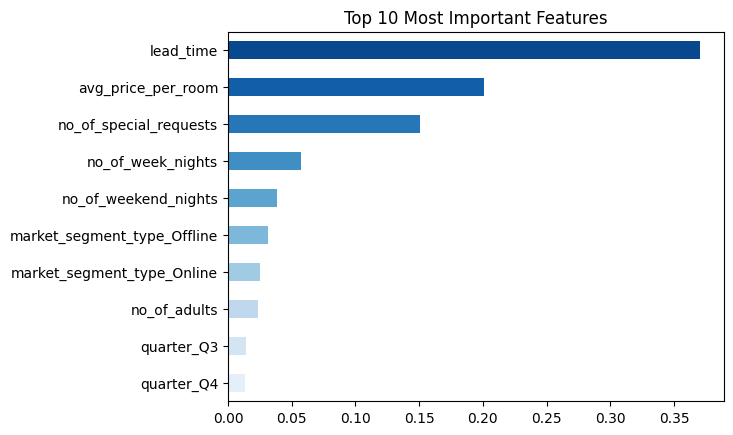

In [22]:
# Define color palette
palette = sns.color_palette("Blues_r", n_colors=10)[::-1]

# Plot feature importance in descending order with custom bar colors
feature_importances = pd.Series(SMOTE_RF_Classifier.feature_importances_, index=X.columns)
sorted_importances = feature_importances.nlargest(10).sort_values(ascending=True)
ax = sorted_importances.plot(kind='barh', color=palette)
ax.set_title('Top 10 Most Important Features')
plt.show()